In [11]:
# Lab 11 MNIST and Convolutional Neural Network
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

from IPython.display import Image

# Understanding CNN operation

## 2D CNN

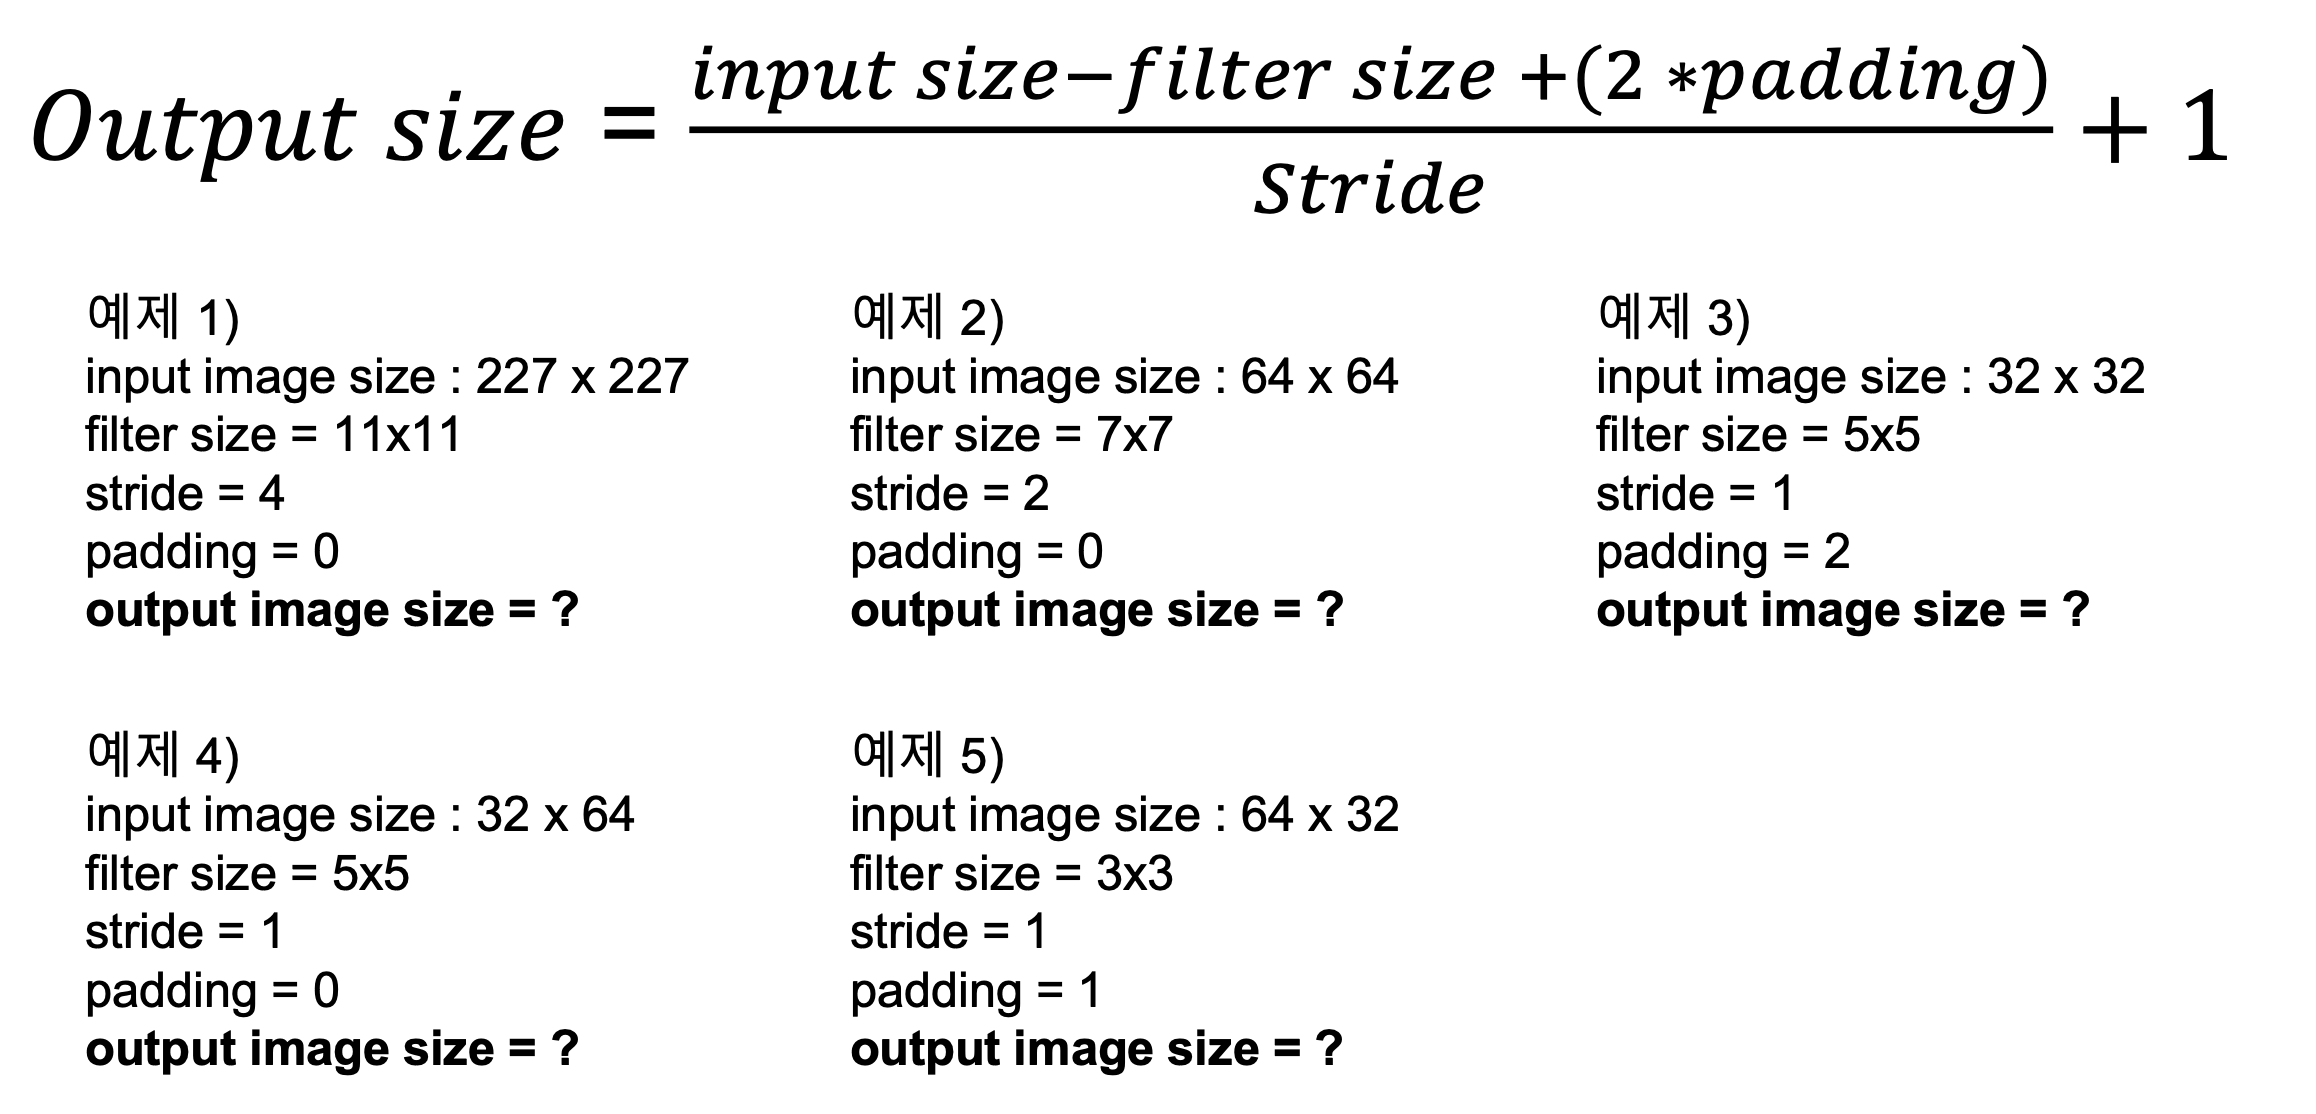

In [16]:
Image('./figures/CNN_output_ex.png')

In [18]:
# Example1
x = torch.randn(1,1,227,227)
CNN_layer = torch.nn.Conv2d(in_channels=1,out_channels=1,kernel_size=(11,11),stride=4,padding=0)
output = CNN_layer(x)
print(output.shape)

torch.Size([1, 1, 55, 55])


In [ ]:
# Example2 만약 안 나눠떨어진다면? 가우스 [공식]  혹은 내림이라고 생각하자
x = torch.randn(1,1,64,64)
CNN_layer = torch.nn.Conv2d(in_channels=1,out_channels=1,kernel_size=(7,7),stride=2,padding=0)
output = CNN_layer(x)
print(output.shape)

In [21]:
#Example 3
x = torch.randn(1,1,32,32)
CNN_layer = torch.nn.Conv2d(in_channels=1,out_channels=1,kernel_size=(5,5),stride=1,padding=2)
output = CNN_layer(x)
print(output.shape)

torch.Size([1, 1, 32, 32])


In [22]:
#Example4 - pytorch에는 자동으로 맞춰주는 기능이 없음. Tip! (kernel=홀수 / stride=1) 경우 padding = [kernel size/2])
x = torch.randn(1,1,64,32)
CNN_layer = torch.nn.Conv2d(in_channels=1,out_channels=1,kernel_size=(3,3),stride=1,padding=1)
output = CNN_layer(x)
print(output.shape)

torch.Size([1, 1, 64, 32])


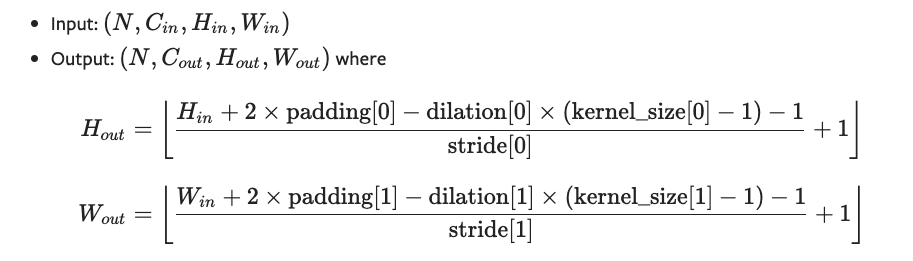

In [41]:
Image('./figures/CNN_output2.png')

## 1D CNN

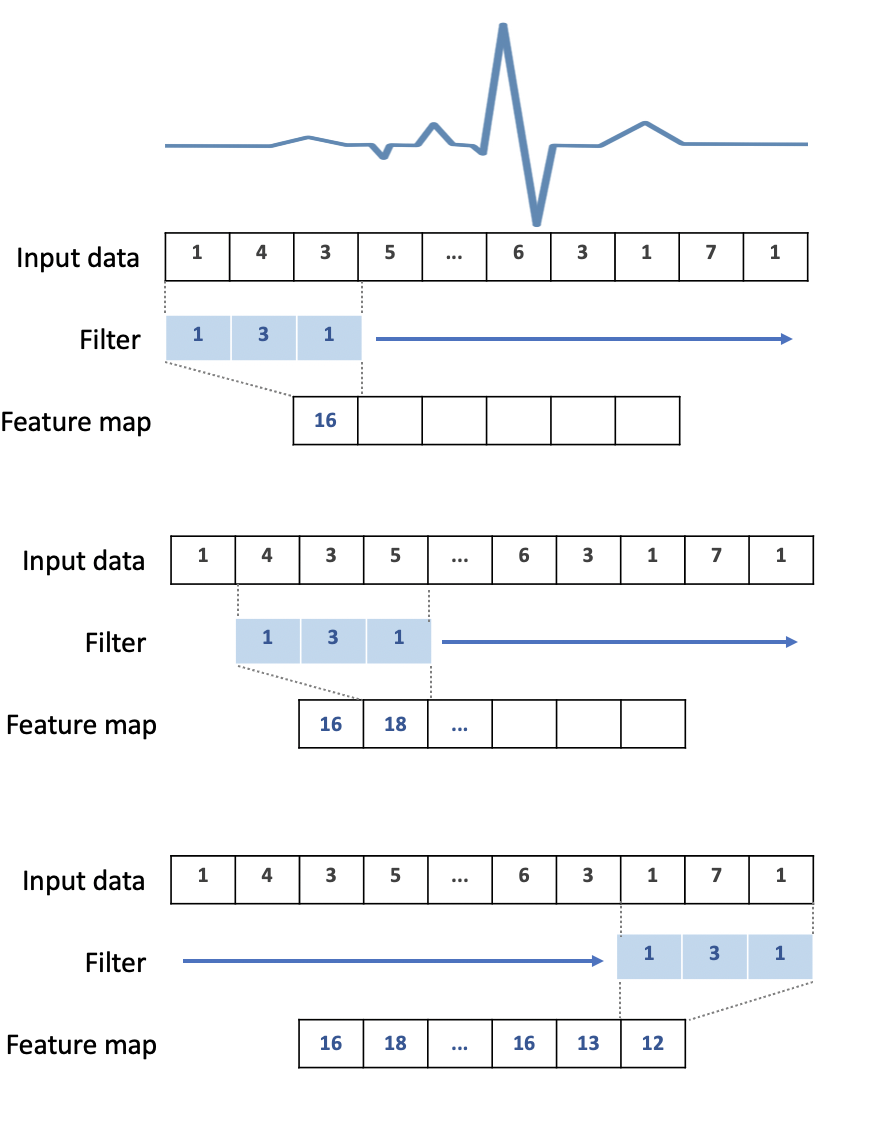

In [24]:
Image('./figures/1DCNN_1.png')

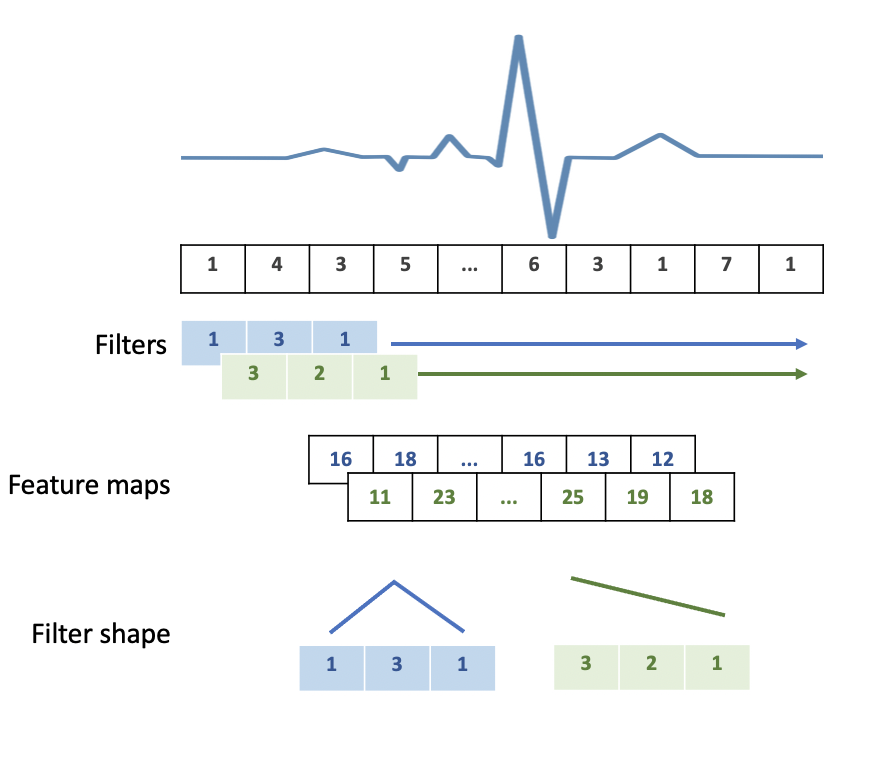

In [25]:
Image('./figures/1DCNN_2.png')

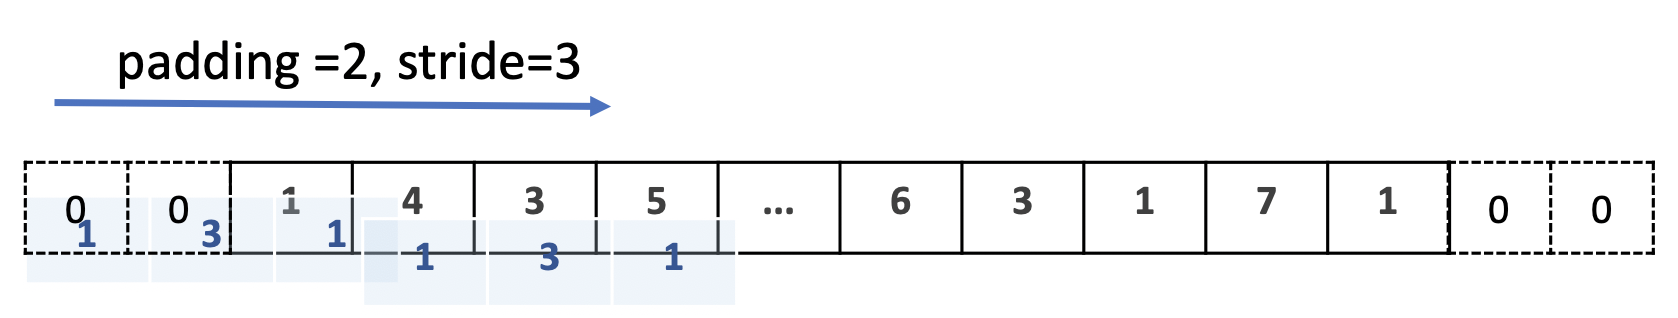

In [27]:
Image('./figures/1DCNN_4.png')

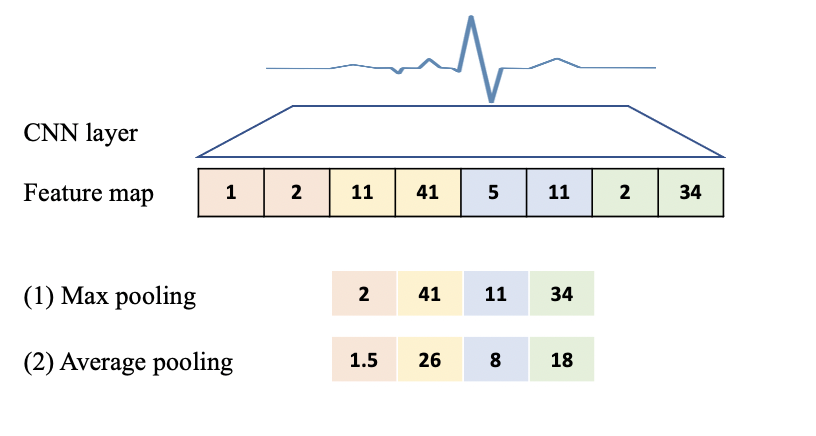

In [28]:
Image('./figures/1DCNN_3.png')

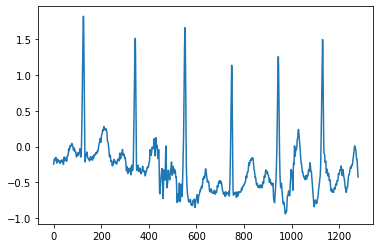

In [32]:
from scipy.misc import electrocardiogram 
import matplotlib.pyplot as plt
#Example1
ecg = electrocardiogram()  #128Hz
plt.plot(ecg[:128*10])
plt.show()

In [39]:
# Exmaple1 : 1D CNN에는 Batch*Channel*length
x = torch.from_numpy(ecg[:128*10]).float()
x = x.view(1,1,-1)
CNN_layer = torch.nn.Conv1d(in_channels=1,out_channels=1,kernel_size=3,stride=1,padding=3)
output = CNN_layer(x)
print(output.shape)

torch.Size([1, 1, 1284])


## Pooling

In [51]:
x = torch.arange(0,16,1).view(1,1,4,4).float()
print(x)

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])


In [53]:
pooling_max_layer = torch.nn.MaxPool2d(kernel_size=(2,2),stride=1)
output = pooling_max_layer(x)
print(output.shape)
print(output)

torch.Size([1, 1, 3, 3])
tensor([[[[ 5.,  6.,  7.],
          [ 9., 10., 11.],
          [13., 14., 15.]]]])


In [55]:
pooling_avg_layer = torch.nn.AvgPool2d(kernel_size=(2,2),stride=1)
output = pooling_avg_layer(x)
print(output.shape)
print(output)

torch.Size([1, 1, 3, 3])
tensor([[[[ 2.5000,  3.5000,  4.5000],
          [ 6.5000,  7.5000,  8.5000],
          [10.5000, 11.5000, 12.5000]]]])


# MNIST example

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [3]:
# parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [4]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [5]:
# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [6]:
# CNN Model (2 conv layers)
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # L1 ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L2 ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # Final FC 7x7x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc(out)
        return out

In [7]:
# instantiate CNN model
model = CNN().to(device)

In [8]:
# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
# train my model
total_batch = len(data_loader)
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

print('Learning Finished!')

Learning started. It takes sometime.
[Epoch:    1] cost = 0.223962948
[Epoch:    2] cost = 0.0621968508
[Epoch:    3] cost = 0.04496786
[Epoch:    4] cost = 0.0355039984
[Epoch:    5] cost = 0.0289577842
[Epoch:    6] cost = 0.0248987898
[Epoch:    7] cost = 0.0207361449
[Epoch:    8] cost = 0.0181791186
[Epoch:    9] cost = 0.0151967173
[Epoch:   10] cost = 0.0123909712
[Epoch:   11] cost = 0.0103712706
[Epoch:   12] cost = 0.0097719552
[Epoch:   13] cost = 0.008124399
[Epoch:   14] cost = 0.00715200789
[Epoch:   15] cost = 0.006248652
Learning Finished!


In [10]:
# Test model and check accuracy
with torch.no_grad():
    model.eval()
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.9860000014305115


/home/jjong/anaconda3/envs/torch_v1.3/lib/python3.6/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/jjong/anaconda3/envs/torch_v1.3/lib/python3.6/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
